# Module's version

- python==3.8.2
- pandas==1.1.3
- numpy==1.18.5
- feature_engine==1.1.2
- scikit-learn==0.23.2
- keras==2.4.0
- tensorflow==2.3.0
- tqdm==4.50.2

In [1]:
!python3 -V
import os
import pandas
import numpy
import feature_engine
import sklearn
import keras
import tensorflow
import tqdm

print("cores:", os.cpu_count())
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("feature_engine:", feature_engine.__version__)
print("sklearn:", sklearn.__version__)
print("keras:", keras.__version__)
print("tensorflow:", tensorflow.__version__)
print("tqdm:", tqdm.__version__)

Python


cores: 12
pandas: 1.1.3
numpy: 1.19.5
feature_engine: 1.1.2
sklearn: 0.23.2
keras: 2.4.0
tensorflow: 2.4.1
tqdm: 4.50.2


Using TensorFlow backend.


In [54]:
# !pip install pandas==1.1.3 numpy==1.18.5 feature_engine==1.1.2 scikit-learn==0.23.2 keras==2.4.0 tensorflow==2.3.0 tqdm==4.50.2

# 요약

## 전처리 조합

- np.random.seed(0)
- train_test_split random_state = 777
- 중복 레코드 제거
- 단일 클래스 피처 제거
- Outlier IQR 기준 3 삭제
- Feature 간 상관계수 0.7 이상 삭제
- MaxAbsScaler 적용
- Class_weight 적용
- Keras Logistic Regression
- L2 Regularization lambda = 0.0001
- Early stopping monitor = val_loss, patience = 10, min_delta = 0.01
- Stratified K-Fold K = 5
- tf.random.set_seed() 함수를 통해 random_state 조정, 10~100 까지 10 단위 10 개의 모델을 만들어 ROC-AUC-Score 평균을 냄

## 성능

- ROC-AUC-Score : 0.93202427

In [2]:
import pandas as pd
import numpy as np
from feature_engine.outliers import OutlierTrimmer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import keras.models as models
import keras.layers as layers
import keras.metrics as metrics
import keras.regularizers as regularizers
import tensorflow.keras.callbacks as callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore', UserWarning)
warnings.filterwarnings(action='ignore')
np.random.seed(0)

## 데이터 불러오기

In [4]:
data = pd.read_csv('Train.csv')
data

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,1,1,2.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1759,40,200,5.0000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1760,96,218,2.2708,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1761,16,81,5.0625,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 데이터 전처리

## X, Y 분리

In [5]:
X = data.drop(['Class'], axis=1)
Y = data['Class']

In [6]:
Y.value_counts()

0    1620
1     143
Name: Class, dtype: int64

## Train set, Test set 분리

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=777, stratify=Y)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [8]:
# 분리 확인
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1410, 1558) (353, 1558) (1410,) (353,)


In [9]:
# Y 밸런스 확인
Y_train.value_counts()

0    1296
1     114
Name: Class, dtype: int64

## 중복 레코드 제거

In [10]:
temp = pd.concat([X_train, Y_train], axis=1)

In [11]:
temp.drop_duplicates(keep='first', inplace=True)

In [12]:
Y_train = temp['Class']
X_train = temp.drop(['Class'], axis=1)

In [13]:
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [14]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1378, 1558) (1378,) (353, 1558) (353,)


## 단일 클래스를 가진 피쳐 제거

In [15]:
for i in X_train.columns:
    if len(X_train[i].unique()) == 1:
        X_train.drop(i, axis=1, inplace=True)
        X_test.drop(i, axis=1, inplace=True)

In [16]:
# 감소한 피쳐 수 확인
print(X_train.shape, X_test.shape)

(1378, 1515) (353, 1515)


## Outlier 처리 #1 iqr 기준 삭제

In [17]:
toScale = ["feature_1", "feature_2" , "feature_3"]

In [18]:
trimmer = OutlierTrimmer(capping_method='iqr', tail='both', fold=3, variables=toScale)
X_train = trimmer.fit_transform(X_train)

In [19]:
Y_train = Y_train[X_train.index]

X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

In [20]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1360, 1515) (1360,) (353, 1515) (353,)


## Train set Feature Scaling

## Feature간 상관계수 계산 후 제거

In [21]:
corr = []

for i in X_train.columns:
    corr.append(abs(np.corrcoef(X_train[i], Y_train)[0][1]))
corrX_Y = pd.DataFrame(columns=['features', 'corr'])
corrX_Y['features'] = X_train.columns
corrX_Y['corr'] = corr

In [22]:
corr_mat = X_train.corr()

In [23]:
corr_mat = abs(corr_mat)
#corr_mat.to_csv('./corr_mat.csv', index=True)

In [24]:
overCorr = pd.DataFrame(columns=['INDEX', 'COLUMN', 'CORR'])
INDEX, COLUMN, CORR = [], [], []
for i in range(len(corr_mat.index)):
    for j in range(i+1, len(corr_mat.columns)):
        if corr_mat.iloc[i, j] > 0.7:
            #print(corr_mat.index[i], corr_mat.columns[j], corr_mat.iloc[i, j])
            INDEX.append(corr_mat.index[i])
            COLUMN.append(corr_mat.columns[j])
            CORR.append(corr_mat.iloc[i, j])
overCorr['INDEX'] = INDEX
overCorr['COLUMN'] = COLUMN
overCorr['CORR'] = CORR

In [25]:
overCorr

,INDEX,COLUMN,CORR
0,feature_6,feature_245,1.000000
1,feature_6,feature_487,1.000000
2,feature_6,feature_596,1.000000
3,feature_6,feature_958,0.774026
4,feature_6,feature_1197,0.774026
...,...,...,...
6091,feature_1541,feature_1550,0.815894
6092,feature_1542,feature_1555,0.972966
6093,feature_1542,feature_1556,1.000000
6094,feature_1545,feature_1557,0.796544


## Feature간 상관계수 계산 후 제거 (코드 일부)

In [26]:
for i in overCorr.index:
    try:
        if corrX_Y[corrX_Y['features'] == overCorr.loc[i]['INDEX']]['corr'].values[0] <= \
        corrX_Y[corrX_Y['features'] == overCorr.loc[i]['COLUMN']]['corr'].values[0]:
            X_train.drop([overCorr.loc[i]['INDEX']], axis=1, inplace=True)
            X_test.drop([overCorr.loc[i]['INDEX']], axis=1, inplace=True)
        else:
            X_train.drop([overCorr.loc[i]['COLUMN']], axis=1, inplace=True)
            X_test.drop([overCorr.loc[i]['COLUMN']], axis=1, inplace=True)
    except:
        continue

In [27]:
X_train.shape

(1360, 412)

## Feature Scaling #4 MaxAbsScaler

In [28]:
maxabsScaler = MaxAbsScaler()
for feature in toScale:
    X_train.loc[:, feature] = maxabsScaler.fit_transform(X_train[feature].to_numpy().reshape(-1, 1))
    X_test.loc[:, feature] = maxabsScaler.transform(X_test[feature].to_numpy().reshape(-1, 1))

## 오버샘플링 #0 안함

In [29]:
# Y 밸런스 확인
Y_train.value_counts()

0    1247
1     113
Name: Class, dtype: int64

## 오버샘플링 진행 후 단일 클래스 가진 피쳐 제거

In [30]:
for i in X_train.columns:
    if len(X_train[i].unique()) == 1:
        X_train.drop(i, axis=1, inplace=True)
        X_test.drop(i, axis=1, inplace=True)

In [31]:
# 감소한 피쳐 수 확인
print(X_train.shape, X_test.shape)

(1360, 408) (353, 408)


# 모델 학습

## Class_weight 적용

In [32]:
weight_0 = (1 / Y_train.value_counts()[0]) * (Y_train.value_counts().sum() / 2.0)
weight_1 = (1 / Y_train.value_counts()[1]) * (Y_train.value_counts().sum() / 2.0)
class_weight = {0 : weight_0, 1 : weight_1}
print(class_weight)

{0: 0.545308740978348, 1: 6.017699115044247}


## Model History callback class

In [33]:
class ModelHistory(callbacks.Callback):
    def __init__(self, logs={}):
        self.history = {'loss' : [], 'binary_accuracy' : [], 'val_loss' : [], 'val_binary_accuracy' : []}

    def on_epoch_end(self, batch, logs={}):
        self.history['loss'].append(logs['loss'])
        self.history['binary_accuracy'].append(logs['binary_accuracy'])
        self.history['val_loss'].append(logs['val_loss'])
        self.history['val_binary_accuracy'].append(logs['val_binary_accuracy'])

# Keras Logistic regression

In [34]:
AUCScores_log = np.zeros(10)
model_log = [0 for _ in range(10)]
for i in range(10, 101, 10):
    tf.random.set_seed(i)
    model_log[int(i/10 - 1)] = models.Sequential(name=f"Keras_log_Random_state_{i}")
    model_log[int(i/10 - 1)].add(layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],), \
                              kernel_regularizer=regularizers.l2(0.0001)))
    model_log[int(i/10 - 1)].compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

    kfold = StratifiedKFold(n_splits=5)
    modelHistory = ModelHistory()
    cb = [callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01), \
         modelHistory]
    with tqdm(total=5, ascii=True) as pbar:
        for train_index, test_index in kfold.split(X_train, Y_train):
            X_train_log, X_val_log = X_train.loc[train_index], X_train.loc[test_index]
            Y_train_log, Y_val_log = Y_train.loc[train_index], Y_train.loc[test_index]
            model_log[int(i/10 - 1)].fit(X_train_log, Y_train_log, validation_data=(X_val_log, Y_val_log), \
                          epochs=50, use_multiprocessing=True, workers=-1, verbose=0, \
                          callbacks=cb, class_weight=class_weight)
            pbar.update(1)

    model_log_pred = model_log[int(i/10 - 1)].predict(X_test)
    AUCScores_log[int(i/10 - 1)] = roc_auc_score(Y_test, model_log_pred)

print(AUCScores_log.mean().round(8))

100%|####################################################################################| 5/5 [00:04<00:00,  1.16it/s]

0.93202427


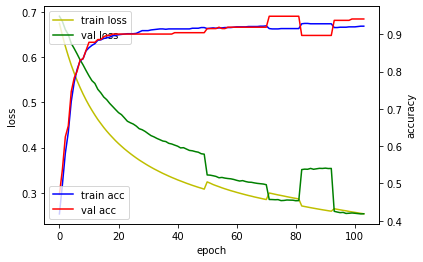

In [35]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(modelHistory.history['loss'], 'y', label='train loss')
loss_ax.plot(modelHistory.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(modelHistory.history['binary_accuracy'], 'b', label='train acc')
acc_ax.plot(modelHistory.history['val_binary_accuracy'], 'r', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()